In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
import scanpy as sc,anndata as ad
import squidpy as sq
import os
import re
import sys
from scipy.sparse import vstack
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler,scale
from scipy.spatial import distance_matrix, distance
from sklearn.neighbors import KernelDensity
from scipy.spatial import KDTree
from scipy.spatial.distance import cdist
import networkx as nx
from sklearn.neighbors import NearestNeighbors
from tqdm import tqdm
from sklearn.neighbors import BallTree
import time
import rdata
from scipy.sparse import csr_matrix,bsr_matrix,coo_matrix,issparse,lil_matrix,diags
from scipy.sparse.linalg import inv
import scipy as sp
from  scipy.ndimage import gaussian_filter
import igraph as ig
import glasbey
import warnings
import cairocffi as cairo
from sklearn.metrics import adjusted_rand_score,make_scorer
from sklearn.model_selection import GridSearchCV, ParameterGrid
from sklearn import preprocessing
import libpysal
from esda.losh import LOSH
from multiprocessing import Pool
from mclustpy import mclustpy
from sklearn.cluster import KMeans
import torch
#from GraphST import GraphST
import SEDR
#from GraphST.utils import clustering
from matplotlib.colors import ListedColormap
from esda import Moran
from libpysal.weights import KNN
from scsampler import scsampler 
from geosketch import gs
from scvalue import SCValue
from tqdm import tqdm
from fbpca import pca
from annoy import AnnoyIndex
from sklearn.metrics.pairwise import cosine_similarity
from scipy.spatial.distance import jensenshannon
from sklearn.metrics import mean_squared_error
from numpy.linalg import norm 
import glob
import itertools

/dartfs-hpc/rc/lab/F/FrostH/members/igingerich/envs/miniconda3/envs/r-kernel/lib/python3.12/site-packages/anndata/utils.py:429: FutureWarning: Importing read_text from `anndata` is deprecated. Import anndata.io.read_text instead.
  warnings.warn(msg, FutureWarning)


In [2]:
class RASP:
    @staticmethod
    def build_weights_matrix(adata, n_neighbors=6, beta=2, platform='visium'):
        """
        Build a sparse distance matrix including only the K nearest neighbors, and compute inverse weighting.

        Parameters:
        - adata: Annotated data object.
        - n_neighbors: int - number of nearest neighbors to include.
        - beta: weight exponent parameter.
        - platform: string - type of platform.

        Returns:
        - sparse_distance_matrix: csr_matrix - sparse distance matrix of shape (n_samples, n_samples).
        """
        coords = adata.obsm['spatial']
        nbrs = NearestNeighbors(n_neighbors=n_neighbors, algorithm='auto').fit(coords)
        distances, indices = nbrs.kneighbors(coords)

        # Build the sparse matrix
        data = distances.flatten()
        row_indices = np.repeat(np.arange(coords.shape[0]), n_neighbors)
        col_indices = indices.flatten()
        sparse_distance_matrix = coo_matrix((data, (row_indices, col_indices)), shape=(coords.shape[0], coords.shape[0])).tocsr()

        # Remove outliers
        temp_matrix = sparse_distance_matrix.tocoo()
        percentile_99 = np.percentile(temp_matrix.data, 99)
        temp_matrix.data[temp_matrix.data > percentile_99] = 0
        sparse_distance_matrix = temp_matrix.tocsr()

        # Invert and exponentiate non-zero values
        non_zero_values = sparse_distance_matrix.data[sparse_distance_matrix.data > 0]
        min_non_zero_value = np.min(non_zero_values) if non_zero_values.size > 0 else 1

        if platform == 'visium':
            sparse_distance_matrix.setdiag(min_non_zero_value / 2)
        else:
            sparse_distance_matrix.setdiag(min_non_zero_value)

        inverse_sq_data = np.zeros_like(sparse_distance_matrix.data)
        inverse_sq_data[sparse_distance_matrix.data > 0] = 1 / (sparse_distance_matrix.data[sparse_distance_matrix.data > 0] ** beta)

        inverse_sq_matrix = csr_matrix((inverse_sq_data, sparse_distance_matrix.indices, sparse_distance_matrix.indptr),
                                        shape=sparse_distance_matrix.shape)

        row_sums = inverse_sq_matrix.sum(axis=1).A1
        row_sums[row_sums == 0] = 1
        weights = inverse_sq_matrix.multiply(1 / row_sums[:, np.newaxis])

        return weights

In [3]:
#lets spot check the leverage score on the ovary dataset for now 

directory = "/dartfs-hpc/rc/lab/F/FrostH/members/igingerich/public_data/mouse_MERFISH_data/data"
adata = sc.read_h5ad(os.path.join(directory,"region0_raw_data_only.h5ad"))



gene_scores_df = pd.read_csv('/dartfs-hpc/rc/lab/F/FrostH/members/igingerich/public_data/mouse_MERFISH_data/data/leverage_scores.csv')
pca_leverage_df = pd.read_csv("/dartfs-hpc/rc/lab/F/FrostH/members/igingerich/public_data/mouse_MERFISH_data/data/leverage_scores_pca.csv")
#adata.obs['gene_score'] = gene_scores_df['leverage_score'].values

In [4]:
from scipy.sparse.linalg import svds
from sklearn.utils.extmath import randomized_svd

In [5]:
X = adata.X.toarray()
#mean center 
X_centered = X - X.mean(axis=0)
U, S, VT = randomized_svd(X, n_components = 228, random_state = 42)
U_c, S_c, VT_c = randomized_svd(X_centered, n_components = 228, random_state = 42)

py_scores = np.array(np.sum(U**2, axis = 1))
py_scores_centered = np.array(np.sum(U_c**2,axis = 1))

In [6]:
r_scores = np.array(gene_scores_df['leverage_score'])
pca_scores = np.array(pca_leverage_df['leverage_score'])

In [7]:
#py_scores_norm = py_scores / py_scores.sum()
py_scores_norm = (py_scores - py_scores.min()) / (py_scores.max() - py_scores.min())
py_scores_centered_norm = (py_scores_centered - py_scores_centered.min()/(py_scores_centered.max()-py_scores_centered.min()))
r_scores_norm = (r_scores - r_scores.min()) / (r_scores.max() - r_scores.min())
pca_scores_norm = (pca_scores-pca_scores.min())/(pca_scores.max()-pca_scores.min())

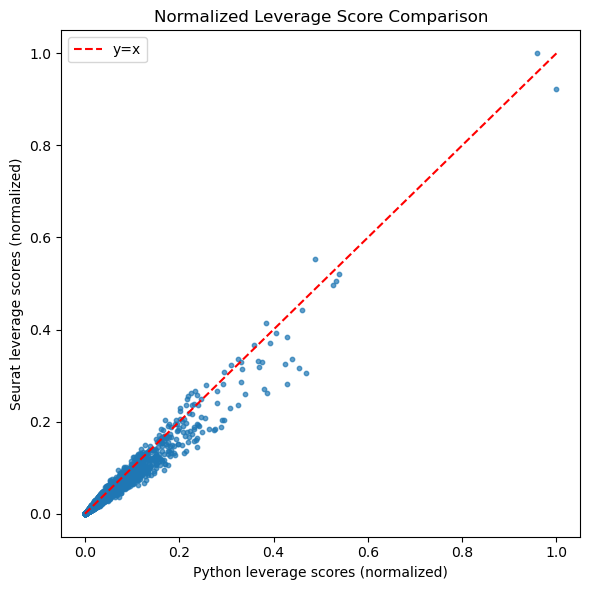

In [10]:
plt.figure(figsize=(6,6))
plt.scatter(py_scores_norm, r_scores_norm, s=10, alpha=0.7)
plt.plot([0, 1], [0, 1], 'r--', label='y=x')
plt.xlabel('Python leverage scores (normalized)')
plt.ylabel('Seurat leverage scores (normalized)')
plt.title('Normalized Leverage Score Comparison')
plt.legend()
plt.tight_layout()
plt.show()

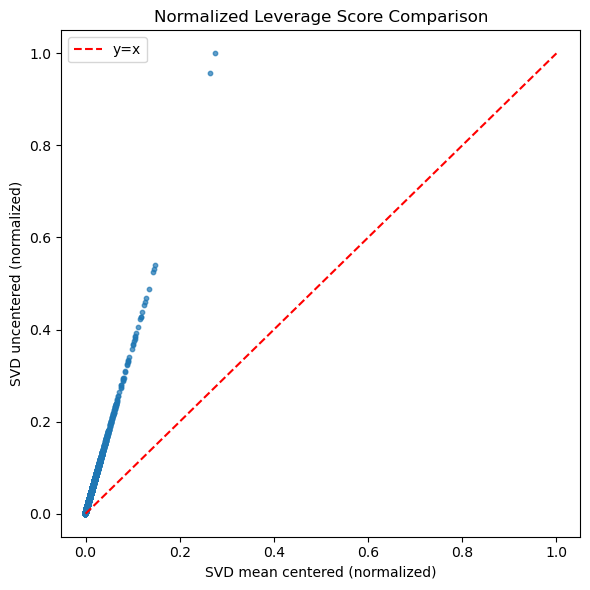

In [13]:
plt.figure(figsize=(6,6))
plt.scatter(py_scores_centered_norm, py_scores_norm, s=10, alpha=0.7)
plt.plot([0, 1], [0, 1], 'r--', label='y=x')
plt.xlabel('SVD mean centered (normalized)')
plt.ylabel('SVD uncentered (normalized)')
plt.title('Normalized Leverage Score Comparison')
plt.legend()
plt.tight_layout()
plt.show()

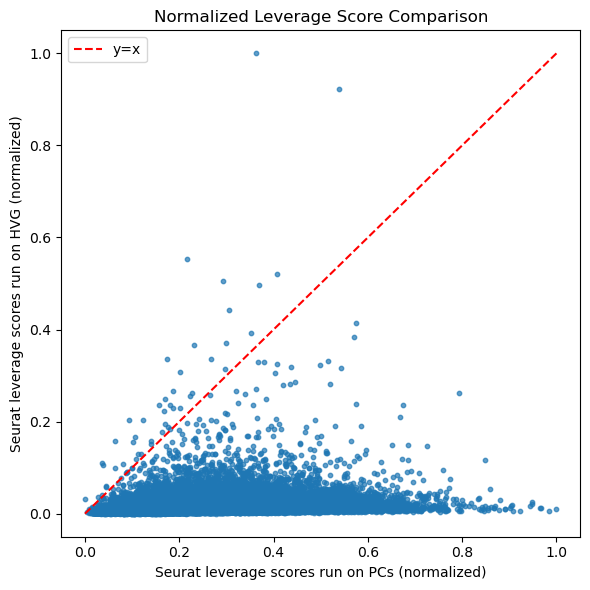

In [10]:
#now for the leverage score on the HVG (or full dataset) vs the levearge score in seurat run on the top k PCs 
plt.figure(figsize=(6,6))
plt.scatter(pca_scores_norm, r_scores_norm, s=10, alpha=0.7)
plt.plot([0, 1], [0, 1], 'r--', label='y=x')
plt.xlabel('Seurat leverage scores run on PCs (normalized)')
plt.ylabel('Seurat leverage scores run on HVG (normalized)')
plt.title('Normalized Leverage Score Comparison')
plt.legend()
plt.tight_layout()
plt.show()

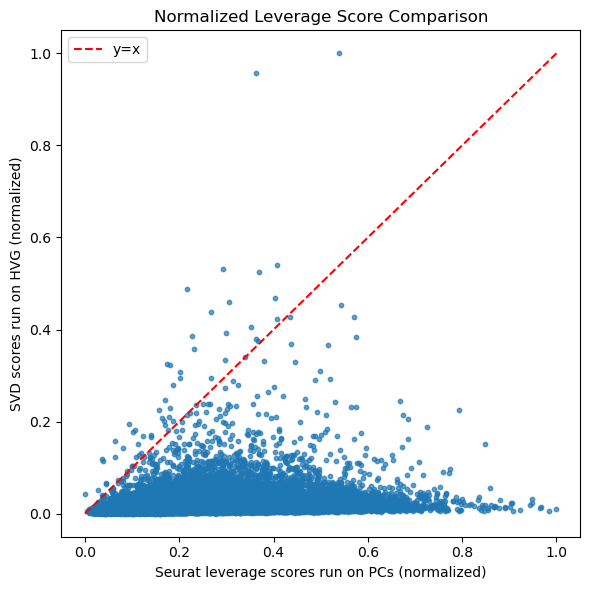

In [11]:
plt.figure(figsize=(6,6))
plt.scatter(pca_scores_norm, py_scores_norm, s=10, alpha=0.7)
plt.plot([0, 1], [0, 1], 'r--', label='y=x')
plt.xlabel('Seurat leverage scores run on PCs (normalized)')
plt.ylabel('SVD scores run on HVG (normalized)')
plt.title('Normalized Leverage Score Comparison')
plt.legend()
plt.tight_layout()
plt.show()

In [29]:
#now we need to be able to run the parameter sweep on the svd leverage score, and svd + rasp leverage score. 
# first we need to make the leverage score calculations for each dataset, and then save the scores as as .csv file for the 
# the metric calculation step. 

#lets do that now for all of the datasets, just rinse and repeat for all the datasets. 

base = "/dartfs-hpc/rc/lab/F/FrostH/members/igingerich/public_data"

input_dir = os.path.join(base,"simulations_for_sketching_analysis/xenium_like_data/stripes/data/processed_data.h5ad")

output_dir = os.path.join(base,"simulations_for_sketching_analysis/xenium_like_data/stripes/data/leverage_score_svd.csv")

#load the dataset 
print("loading data...")
adata = sc.read_h5ad(input_dir)

#svd logic 
rank = 50 
seed = 42 

X = adata.X.toarray()
#mean center 
#X_centered = X - X.mean(axis=0)
print("computing scores...")
U, S, VT = randomized_svd(X, n_components = rank, random_state = seed)
#U_c, S_c, VT_c = randomized_svd(X_centered, n_components = 228, random_state = 42)

py_scores = np.array(np.sum(U**2, axis = 1))
#py_scores_centered = np.array(np.sum(U_c**2,axis = 1))
leverage_df = pd.DataFrame({'leverage_score_svd': py_scores})

# Save to CSV with header
leverage_df.to_csv(output_dir, index=False)
print("finished")






loading data...
computing scores...
finished


In [32]:
#we also need to save a spatially smoothed U matrix as well: 


(99859, 50)

In [45]:
base = "/dartfs-hpc/rc/lab/F/FrostH/members/igingerich/public_data"

input_dir = os.path.join(base,"visium_HD_brain/processed_data/processed_data_8um.h5ad")

output_dir = os.path.join(base,"visium_HD_brain/processed_data/leverage_score_svd_smoothed.csv")

#presets: 
rank = 50 
seed = 42 
kNN_threshold = 30
beta = 2
platform = 'visium'





#load the dataset 
print("loading data...")
adata = sc.read_h5ad(input_dir)

#svd logic 


X = adata.X.toarray()
#mean center 
#X_centered = X - X.mean(axis=0)
print("computing scores...")
U, S, VT = randomized_svd(X, n_components = rank, random_state = seed)


print('building weights...')
weights = RASP.build_weights_matrix(adata, n_neighbors=kNN_threshold, beta = beta, platform = platform)

#spatially smooth the pca_data 
smoothed_svd = weights @ csr_matrix(U)    
# Convert to dense array if needed
smoothed_svd = smoothed_svd.toarray()

py_scores_smoothed = np.array(np.sum(smoothed_svd**2, axis = 1))
leverage_df = pd.DataFrame({'leverage_score_svd_smoothed': py_scores_smoothed})

# Save to CSV with header
leverage_df.to_csv(output_dir, index=False)
print("finished")


loading data...
computing scores...
building weights...
finished
